# Part 3 - Preprocessing, Modelling and Conclusions & Recommendations

This notebook will cover:

- Selection of the X and y features
- Modelling using various model types:
    - K-Nearest Neighbours
    - Random Forest
    - Multinomial Naive Bayes
    - Logistic Regression
    - Support Vector Machine
- Evaluation of chosen model
- Conclusion and Recommendations

In [3]:
# import the necessary libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import svm
from tabulate import tabulate

In [4]:
# import the dataset
onion_or_not = pd.read_csv('../Datasets/onion_or_not.csv')
print(onion_or_not.shape)
onion_or_not.head()

(10000, 8)


,subreddit,title,created_utc,title_length,title_word_count,new_text,newtext_length,newtext_word_count
0,nottheonion,Woman self-isolates in plane toilet for five h...,1640966006,101,14,woman self isolates in plane toilet for five h...,98,16
1,TheOnion,Gwyneth Paltrow Touts New Diamond-Encrusted Tr...,1640955671,89,11,gwyneth paltrow tout new diamond encrusted tre...,87,12
2,TheOnion,Artist Crafting Music Box Hopes It Delights At...,1640955669,81,13,artist crafting music box hope it delight at l...,79,14
3,TheOnion,Homeowner Trying To Smoke Out Snakes Accidenta...,1640955668,66,10,homeowner trying to smoke out snake accidental...,64,10
4,TheOnion,Dictionary.Com Names ‘Allyship’ 2021 Word Of T...,1640955667,53,8,dictionary com name allyship 2021 word of the ...,50,9


## Preprocessing

### Generating Binary Classifier Column

Since we want to create a model that will effectively predict which news is fake, we will use TheOnion as positive, since it is satire and not real news.


**1: TheOnion<br>
0: nottheonion**

In [5]:
# create column for 1s and 0s for subreddit
# TheOnion : 1, notthe onion : 0
onion_or_not['onion'] = [1 if value == 'TheOnion' else 0 for value in onion_or_not.subreddit.values]
onion_or_not.head()

,subreddit,title,created_utc,title_length,title_word_count,new_text,newtext_length,newtext_word_count,onion
0,nottheonion,Woman self-isolates in plane toilet for five h...,1640966006,101,14,woman self isolates in plane toilet for five h...,98,16,0
1,TheOnion,Gwyneth Paltrow Touts New Diamond-Encrusted Tr...,1640955671,89,11,gwyneth paltrow tout new diamond encrusted tre...,87,12,1
2,TheOnion,Artist Crafting Music Box Hopes It Delights At...,1640955669,81,13,artist crafting music box hope it delight at l...,79,14,1
3,TheOnion,Homeowner Trying To Smoke Out Snakes Accidenta...,1640955668,66,10,homeowner trying to smoke out snake accidental...,64,10,1
4,TheOnion,Dictionary.Com Names ‘Allyship’ 2021 Word Of T...,1640955667,53,8,dictionary com name allyship 2021 word of the ...,50,9,1


In [6]:
# as stated in the previous notebook, the classes are perfectly balanced
print(onion_or_not.onion.value_counts(normalize=False))
onion_or_not.onion.value_counts(normalize=True)

0    5000
1    5000
Name: onion, dtype: int64


0    0.5
1    0.5
Name: onion, dtype: float64

### The X and y features

We will use the `new_text` to predict whether a title is from the onion or not. The `new_text` is the tokenized and lemmatized version of the original `title` text.<br>
Hence, our X will be:

In [7]:
X = onion_or_not.new_text
X.head()

0    woman self isolates in plane toilet for five h...
1    gwyneth paltrow tout new diamond encrusted tre...
2    artist crafting music box hope it delight at l...
3    homeowner trying to smoke out snake accidental...
4    dictionary com name allyship 2021 word of the ...
Name: new_text, dtype: object

Our y will simply be the `onion` column of 1s and 0s:

In [8]:
y = onion_or_not.onion
y.head()

0    0
1    1
2    1
3    1
4    1
Name: onion, dtype: int64

### Train, Test and Split

In [9]:
# train, test and split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=y)

## Important metrics for this dataset

### Which is worse, FALSE POSITIVES or FALSE NEGATIVES?

**False Positive - News that is real, but wrongly classified as fake.<br>
False Negative - News that is fake, but wrongly classified as real.**<br>

False positives are important, as the implications of classifying real news as fake can be serious. For example, real news about vaccines being classified as fake can have a serious impact on the healthcare system and vaccination efforts of a nation.

That said, false negatives hold equal importance as well. For example, classifying a fake news about a terrorist attack as real will cause undue panic and anxiety, which will cause unecessary stress the security and defence personnel.

The metrics we will use to evaluate the model are:

- Accuracy = (TP + TN)/(TP + TN + FP + FN)
- Recall = TP/(TP + FN)
- Precision = TP/(TP + FP)
- **f1 Score**

Where TP, TN, FP and FN are **True Positives, True Negatives, False Positives and False Negatives** respectively.

Since avoiding both false positives and false negatives are equally important for our problem, we need a trade-off between precision and recall. We will thus **use the f1 score as the main metric**. The f1 score is defined as the harmonic mean of precision and recall.<sup>1</sup><br>
$$
F1 = 2*\frac{(\text{Precision}*\text{Recall})} {(\text{Precision} + \text{Recall})}
$$

## Modelling

We will model the data using the following models:
- K-Nearest Neighbours
- Random Forest
- Multinomial Naive Bayes
- Support Vector Machine
- Logistic Regression

The model with the best metric will be chosen as our primary model, on which we will perform further study and draw reccomendations and conclusions from.

### Baseline Model
It is tempting to just use accuracy score of 0.5 as the baseline. This however, would be pointless as it is overly basic, and the dataset is deliberately balanced in the first place. We will thus use **k-Nearest Neighbours as the baseline model**:
- It is a proper machine-learning model, yet basic enough for a baseline evaluation.
- It will give us a feel of the dataset, such as whether it overfits, or if there are more false positives than false negatives etc.

In [10]:
# create KNN pipeline
# no default CountVectorizer and KNN will be used as it is a baseline
pipe_knn_base = Pipeline([
    ('cvec', CountVectorizer()), # instantiate CountVectorizer
    ('knn', KNeighborsClassifier()) # Instantiate KNN
])

In [11]:
# fit the train data
pipe_knn_base.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer()), ('knn', KNeighborsClassifier())])

In [12]:
# get the score on the train and test sets
print(f'Baseline train accuracy score: {pipe_knn_base.score(X_train, y_train)}')
print(f'Baseline test accuracy score: {pipe_knn_base.score(X_test, y_test)}')

Baseline train accuracy score: 0.7193333333333334
Baseline test accuracy score: 0.58


The model is overfit, as can be seen by the difference between the train and test scores.

In [13]:
# what are the other test set metrics for baseline KNN model?
print(f'Baseline test RECALL: {recall_score(y_test, pipe_knn_base.predict(X_test))}')
print(f'Baseline test PRECISION: {precision_score(y_test, pipe_knn_base.predict(X_test))}')
print(f'Baseline test f1 SCORE: {f1_score(y_test, pipe_knn_base.predict(X_test))}')

Baseline test RECALL: 0.5688
Baseline test PRECISION: 0.5818330605564648
Baseline test f1 SCORE: 0.5752427184466019


**Summary of the test scores for the baseline KNN Model**

In [14]:
print(tabulate([['Metric', 'Score'],
                ['Accuracy', pipe_knn_base.score(X_test, y_test)],
               ['Recall', recall_score(y_test, pipe_knn_base.predict(X_test))],
               ['Precision', precision_score(y_test, pipe_knn_base.predict(X_test))],
               ['f1 Score', f1_score(y_test, pipe_knn_base.predict(X_test))]],
               headers='firstrow'))

Metric        Score
---------  --------
Accuracy   0.58
Recall     0.5688
Precision  0.581833
f1 Score   0.575243


Scores for the metrics are relatively close to each other, around **0.57 - 0.58**, and are overall not that good.<br>

### k-Nearest Neighbors (KNN) Model Hyperparameter Tuning
Since the baseline performed rather poorly, we will tune the hyperparameters of the the KNN model to see if the score can be improved.

In [15]:
# create KNN pipeline
pipe_knn = Pipeline([
    ('cvec', CountVectorizer()), # instantiate CountVectorizer
    ('knn', KNeighborsClassifier()) # Instantiate KNN
])

In [16]:
# CountVectorizer and KNN parameters
pipe_knn_params = {
    'cvec__max_features': [None, 1000, 2000, 3000],
    'cvec__min_df': [1, 2, 3],
    'cvec__max_df': [.8, .85],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'cvec__stop_words': [None, 'english'],
    'knn__n_neighbors': [1, 3, 5, 7]
}

In [17]:
# Gridsearch for KNN
gs_knn = GridSearchCV(pipe_knn,
                     param_grid=pipe_knn_params,
                     cv=5,
                     n_jobs=-1)

In [18]:
# fit the training data
gs_knn.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.8, 0.85],
                         'cvec__max_features': [None, 1000, 2000, 3000],
                         'cvec__min_df': [1, 2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'cvec__stop_words': [None, 'english'],
                         'knn__n_neighbors': [1, 3, 5, 7]})

In [19]:
# where are the best parameters in KNN model
print(gs_knn.best_params_)

# best score for KNN model
gs_knn.best_score_

{'cvec__max_df': 0.8, 'cvec__max_features': None, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'knn__n_neighbors': 1}


0.5985333333333334

In [20]:
# what are the KNN accuracy scores?
print(f'KNN train accuracy score: {gs_knn.score(X_train, y_train)}')
print(f'KNN test accuracy score: {gs_knn.score(X_test, y_test)}')

KNN train accuracy score: 1.0
KNN test accuracy score: 0.6048


A number of observations can be seen by comparing the KNN model with hyperparameter tuning with the baseline.
- No removal of stopwords worked best for this model.
- Uni-grams only worked best for this model
- The nearest neighbours that worked best for this model is **1**.
- Although scores have improved slightly over the baseline, overfitting is still present, and severe, with train accuracy being **1.0**.

This will help with adjusting the parameters for the other models later.

In [21]:
# what are the test scores of the other metrics for KNN model
print(f'KNN test RECALL: {recall_score(y_test, gs_knn.predict(X_test))}')
print(f'KNN test PRECISION: {precision_score(y_test, gs_knn.predict(X_test))}')
print(f'KNN test f1 SCORE: {f1_score(y_test, gs_knn.predict(X_test))}')

KNN test RECALL: 0.6952
KNN test PRECISION: 0.5887533875338753
KNN test f1 SCORE: 0.6375641966250917


There is significant improvement for Recall, and f1 Scores relative to the baseline, and marginal improvement for accuracy and recall relative to the baseline.<br>
Although there is improvement over the baseline, it is not significant.

**Summary of the test scores for the KNN Model with hyperparameter tuning**

In [22]:
print(tabulate([['Metric', 'Score'],
                ['Accuracy', gs_knn.score(X_test, y_test)],
               ['Recall', recall_score(y_test, gs_knn.predict(X_test))],
               ['Precision', precision_score(y_test, gs_knn.predict(X_test))],
               ['f1 Score', f1_score(y_test, gs_knn.predict(X_test))]],
               headers='firstrow'))

Metric        Score
---------  --------
Accuracy   0.6048
Recall     0.6952
Precision  0.588753
f1 Score   0.637564


### Random Forest with hyperparameter tuning

In [23]:
# pipeline for RandomForest
pipe_rf = Pipeline([
    ('cvec', CountVectorizer()), # instantiate CountVectorizer
    ('rf', RandomForestClassifier()) # instantiate RandomForest
])

In [24]:
# CountVectorizer and RandomForest parameters
pipe_rf_params = {
    'cvec__max_features': [None, 1000, 2000, 3000],
    'cvec__min_df': [1, 2, 3],
    'cvec__max_df': [.8, .85],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'cvec__stop_words': [None, 'english'],
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 1, 2, 3, 4, 5],
    'rf__random_state': [42],
}

In [25]:
# GridSearch for RandomForest
gs_rf = GridSearchCV(pipe_rf,
                     param_grid=pipe_rf_params,
                     cv=5,
                     n_jobs=-1)

In [26]:
# Fit the training data to the RandomForest model
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.8, 0.85],
                         'cvec__max_features': [None, 1000, 2000, 3000],
                         'cvec__min_df': [1, 2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'cvec__stop_words': [None, 'english'],
                         'rf__max_depth': [None, 1, 2, 3, 4, 5],
                         'rf__n_estimators': [100, 200, 300],
                         'rf__random_state': [42]})

In [27]:
# where are the best parameters in RandomForest model
print(gs_rf.best_params_)

# best score for RandForest model
gs_rf.best_score_

{'cvec__max_df': 0.8, 'cvec__max_features': None, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': None, 'rf__max_depth': None, 'rf__n_estimators': 300, 'rf__random_state': 42}


0.7410666666666667

In [28]:
# what are the RandomForest accuracy scores?
print(f'RandomForest train accuracy score: {gs_rf.score(X_train, y_train)}')
print(f'RandomForest test accuracy score: {gs_rf.score(X_test, y_test)}')

RandomForest train accuracy score: 1.0
RandomForest test accuracy score: 0.7496


Some interesting observations for RandomForest:
- Better accuracy than KNN with hyperparameter tuning and baseline, but still overfit, with train score being **1.0**.
- Uni-grams to bi-gram range work best for this model.
- No stop words were removed, which was the best for this model.

In [29]:
# what are the test scores of the other metrics for RandomForest model
print(f'RandomForest test RECALL: {recall_score(y_test, gs_rf.predict(X_test))}')
print(f'RandomForest test PRECISION: {precision_score(y_test, gs_rf.predict(X_test))}')
print(f'RandomForest test f1 SCORE: {f1_score(y_test, gs_rf.predict(X_test))}')

RandomForest test RECALL: 0.7128
RandomForest test PRECISION: 0.7694300518134715
RandomForest test f1 SCORE: 0.7400332225913621


A significant improvement over the KNN with hyperparameter tuning and baseline across all metrics.<br>
f1 score is starting to look more promising at **0.74**, f1 score being the most important metric in determining the chosen model for this project.

**Summary of the test scores for the RandomForest Model with hyperparameter tuning**

In [30]:
print(tabulate([['Metric', 'Score'],
                ['Accuracy', gs_rf.score(X_test, y_test)],
               ['Recall', recall_score(y_test, gs_rf.predict(X_test))],
               ['Precision', precision_score(y_test, gs_rf.predict(X_test))],
               ['f1 Score', f1_score(y_test, gs_rf.predict(X_test))]],
               headers='firstrow'))

Metric        Score
---------  --------
Accuracy   0.7496
Recall     0.7128
Precision  0.76943
f1 Score   0.740033


### Multinomial Naive Bayes (MNB) with hyperparameter tuning

In [31]:
# create a pipeline for MNB
pipe_nb = Pipeline([
    ('cvec', CountVectorizer()), # instantiate CountVectorizer
    ('nb', MultinomialNB()) # instantiate MNB
])

In [32]:
# CountVectorizer and MNB parameters
pipe_nb_params = {
    'cvec__max_features': [None, 1000, 2000, 3000],
    'cvec__min_df': [1, 2, 3],
    'cvec__max_df': [.8, .85],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'cvec__stop_words': [None, 'english'],
    'nb__alpha': np.linspace(0.5, 1.8, 8),
    'nb__fit_prior': [True, False]
}

In [33]:
# Instantiate GridSearchCV for MNB
gs_nb = GridSearchCV(pipe_nb, 
                     param_grid=pipe_nb_params,
                     cv=5,
                     n_jobs=-1)

In [34]:
# fit the training data to the MNB model
gs_nb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.8, 0.85],
                         'cvec__max_features': [None, 1000, 2000, 3000],
                         'cvec__min_df': [1, 2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'cvec__stop_words': [None, 'english'],
                         'nb__alpha': array([0.5       , 0.68571429, 0.87142857, 1.05714286, 1.24285714,
       1.42857143, 1.61428571, 1.8       ]),
                         'nb__fit_prior': [True, False]})

In [35]:
# where are the best parameters in MNB model
print(gs_nb.best_params_)

# best score for MNB model
gs_nb.best_score_

{'cvec__max_df': 0.8, 'cvec__max_features': None, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': None, 'nb__alpha': 1.6142857142857143, 'nb__fit_prior': True}


0.7847999999999999

In [36]:
# what are the MNB accuracy scores?
print(f'MNB train accuracy score: {gs_nb.score(X_train, y_train)}')
print(f'MNB test accuracy score: {gs_nb.score(X_test, y_test)}')

MNB train accuracy score: 0.984
MNB test accuracy score: 0.7908


Interesting observations from MNB:
- Uni-grams to bi-grams range worked the best
- No stop word removal worked best for the model
- alpha value of **1.6142857142857143**
- Model is strong predictor with a relatively high test score, but still overfit.

In [37]:
# what are the test scores of the other metrics for MNB model
print(f'MNB test RECALL: {recall_score(y_test, gs_nb.predict(X_test))}')
print(f'MNB test PRECISION: {precision_score(y_test, gs_nb.predict(X_test))}')
print(f'MNB test f1 SCORE: {f1_score(y_test, gs_nb.predict(X_test))}')

MNB test RECALL: 0.8184
MNB test PRECISION: 0.775587566338135
MNB test f1 SCORE: 0.7964188400155703


All metrics have relatively high scores compared , with RECALL being the highest at **0.8184**, and PRECISION being the lowest at **0.7756**, which is indicative that the model predicted more false positives than false negatives.<br>
f1 score outperforms that of baseline, and KNN and RandomForest with hyperparameter tuning by a significant margin.

**Summary of the test scores for the RandomForest Model with hyperparameter tuning**

In [38]:
print(tabulate([['Metric', 'Score'],
                ['Accuracy', gs_nb.score(X_test, y_test)],
               ['Recall', recall_score(y_test, gs_nb.predict(X_test))],
               ['Precision', precision_score(y_test, gs_nb.predict(X_test))],
               ['f1 Score', f1_score(y_test, gs_nb.predict(X_test))]],
               headers='firstrow'))

Metric        Score
---------  --------
Accuracy   0.7908
Recall     0.8184
Precision  0.775588
f1 Score   0.796419


### Logistic Regression with hyperparameter tuning

In [39]:
# create pipeline for LogisticRegression
pipe_log = Pipeline([
    ('cvec', CountVectorizer()), # instantiate CountVectorizer
    ('log', LogisticRegression()) # instantiate LogisticRegression
])

In [40]:
pipe_log_params = {
    'cvec__max_features': [None, 1000, 2000, 3000],
    'cvec__min_df': [1, 2, 3],
    'cvec__max_df': [.8, .85],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'cvec__stop_words': [None, 'english'],
    'log__penalty': ['l1', 'l2'],
    'log__max_iter': [100, 300, 500],
    'log__random_state': [42]
}

In [41]:
# Instantiate GridSearchCV for Logistic Regression
gs_log = GridSearchCV(pipe_log, 
                     param_grid=pipe_log_params,
                     cv=5,
                     n_jobs=-1)

In [42]:
# fit the training data to the LogisticRegression model
gs_log.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.76413333        nan 0.76413333        nan 0.76413333
        nan 0.74533333        nan 0.74533333        nan 0.74533333
        nan 0.77626667        nan 0.77626667        nan 0.77626667
        nan 0.75893333        nan 0.75893333        nan 0.75893333
        nan 0.7732            nan 0.7732            nan 0.7732
        nan 0.75786667        nan 0.75786667        nan 0.75786667
        nan 0.7624            nan 0.7624            nan 0.7624
        nan 0.74426667        nan 0.74426667        nan 0.74426667
        nan 0.77133333        nan 0.77133333        nan 0.77133333
        nan 0.74946667        nan 0.74946667        nan 0.74946667
        nan 0.7724            nan 0.7724            nan 0.7724
        nan 0.7496            nan 0.7496            nan 0.7496
        nan 0.7596            nan 0.7596            nan 0.7596
      

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('log', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.8, 0.85],
                         'cvec__max_features': [None, 1000, 2000, 3000],
                         'cvec__min_df': [1, 2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'cvec__stop_words': [None, 'english'],
                         'log__max_iter': [100, 300, 500],
                         'log__penalty': ['l1', 'l2'],
                         'log__random_state': [42]})

In [43]:
# where are the best parameters in LogisticRegression model
print(gs_log.best_params_)

# best score for LogisticRegression model
gs_log.best_score_

{'cvec__max_df': 0.8, 'cvec__max_features': None, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': None, 'log__max_iter': 100, 'log__penalty': 'l2', 'log__random_state': 42}


0.7762666666666667

In [44]:
# what are the LogisticRegression accuracy scores?
print(f'LogisticRegression train accuracy score: {gs_log.score(X_train, y_train)}')
print(f'LogisticRegression test accuracy score: {gs_log.score(X_test, y_test)}')

LogisticRegression train accuracy score: 0.9997333333333334
LogisticRegression test accuracy score: 0.7852


Interesting observations with Logistic Regression:
- Uni-grams to bi-grams worked the best for this model
- No stop words were removed, which worked the best for this model
- l2 penalty, ie Ridge Regression worked best for the model
- Model is also overfit.

In [45]:
# what are the test scores of the other metrics for LogisticRegression model
print(f'LogisticRegression test RECALL: {recall_score(y_test, gs_log.predict(X_test))}')
print(f'LogisticRegression test PRECISION: {precision_score(y_test, gs_log.predict(X_test))}')
print(f'LogisticRegression test f1 SCORE: {f1_score(y_test, gs_log.predict(X_test))}')

LogisticRegression test RECALL: 0.78
LogisticRegression test PRECISION: 0.788197251414713
LogisticRegression test f1 SCORE: 0.7840772014475271


The most consistent model so far, with scores of all metrics being arounf **0.78**.
All scores are relatively high, with Precision being the highest at **0.7882** and Precision being the lowest at **0.78**, which is indicative that the model predicted more slightly more false negatives than false positives.<br>
f1 score outperforms that of baseline, and KNN and RandomForest with hyperparameter tuning, but is slighlty worse than MNB with hyperparameter tuning.

**Summary of the test scores for the Logistic Regression Model with hyperparameter tuning**

In [46]:
print(tabulate([['Metric', 'Score'],
                ['Accuracy', gs_log.score(X_test, y_test)],
               ['Recall', recall_score(y_test, gs_log.predict(X_test))],
               ['Precision', precision_score(y_test, gs_log.predict(X_test))],
               ['f1 Score', f1_score(y_test, gs_log.predict(X_test))]],
               headers='firstrow'))

Metric        Score
---------  --------
Accuracy   0.7852
Recall     0.78
Precision  0.788197
f1 Score   0.784077


### Support Vector Machine (SVM) with hyperparameter tuning

In [47]:
# create pipeline for SVM
pipe_svm = Pipeline([
    ('cvec', CountVectorizer()), # instantiate CountVectorizer
    ('svm', svm.SVC()) # instantiate SVM
])

In [48]:
pipe_svm_params = {
    'cvec__max_features': [None, 1000, 2000, 3000],
    'cvec__min_df': [1, 2, 3],
    'cvec__max_df': [.8, .85],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'cvec__stop_words': [None, 'english'],
    'svm__kernel': ['rbf', 'linear'],
    'svm__gamma': ['scale', 'auto'],
    'svm__random_state': [42]
}

In [49]:
# Instantiate GridSearchCV for SVM
gs_svm = GridSearchCV(pipe_svm, 
                     param_grid=pipe_svm_params,
                     cv=5,
                     n_jobs=-1)

In [50]:
# fit the training data to the SVM model
gs_svm.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('svm', SVC())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.8, 0.85],
                         'cvec__max_features': [None, 1000, 2000, 3000],
                         'cvec__min_df': [1, 2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'cvec__stop_words': [None, 'english'],
                         'svm__gamma': ['scale', 'auto'],
                         'svm__kernel': ['rbf', 'linear'],
                         'svm__random_state': [42]})

In [51]:
# where are the best parameters in SVM model
print(gs_svm.best_params_)

# best score for SVM model
gs_svm.best_score_

{'cvec__max_df': 0.8, 'cvec__max_features': None, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': None, 'svm__gamma': 'scale', 'svm__kernel': 'linear', 'svm__random_state': 42}


0.7694666666666666

In [52]:
# what are the SVM accuracy scores?
print(f'SVM train accuracy score: {gs_svm.score(X_train, y_train)}')
print(f'SVM test accuracy score: {gs_svm.score(X_test, y_test)}')

SVM train accuracy score: 1.0
SVM test accuracy score: 0.7804


Interesting observations from Support Vector Machine:
- Uni-grams tri-grams range worked the best for the model
- No stop word removal worked best for the model
- Linear worked better than Radial Basis Function(rbf) for the kernel parameter
- Model is overfit, with the train score being 1.0.

In [53]:
# what are the test scores of the other metrics for SVM model
print(f'SVM test RECALL: {recall_score(y_test, gs_svm.predict(X_test))}')
print(f'SVM test PRECISION: {precision_score(y_test, gs_svm.predict(X_test))}')
print(f'SVM test f1 SCORE: {f1_score(y_test, gs_svm.predict(X_test))}')

SVM test RECALL: 0.7784
SVM test PRECISION: 0.7815261044176707
SVM test f1 SCORE: 0.7799599198396793


All scores are relatively high, with Recall being the highest at 0.8016 and Precision being the lowest at 0.7731, which is indicative that the model predicted more false positives than false negatives.<br>
f1 score outperforms that of baseline, and KNN, RandomForest and Logistic Regression with hyperparameter tuning, but is slighlty worse than MNB with hyperparameter tuning.

**Summary of the test scores for the Support Vector Machine Model with hyperparameter tuning**

In [54]:
print(tabulate([['Metric', 'Score'],
                ['Accuracy', gs_svm.score(X_test, y_test)],
               ['Recall', recall_score(y_test, gs_svm.predict(X_test))],
               ['Precision', precision_score(y_test, gs_svm.predict(X_test))],
               ['f1 Score', f1_score(y_test, gs_svm.predict(X_test))]],
               headers='firstrow'))

Metric        Score
---------  --------
Accuracy   0.7804
Recall     0.7784
Precision  0.781526
f1 Score   0.77996


## Summary of modelling scores

In [55]:
print(tabulate([['Model', 'Accuracy', 'Recall', 'Precision', 'f1 Score'],
                ['Baseline', pipe_knn_base.score(X_test, y_test), recall_score(y_test, pipe_knn_base.predict(X_test)), precision_score(y_test, pipe_knn_base.predict(X_test)), f1_score(y_test, pipe_knn_base.predict(X_test))],
               ['k-Nearest Neighbors', gs_knn.score(X_test, y_test), recall_score(y_test, gs_knn.predict(X_test)), precision_score(y_test, gs_knn.predict(X_test)), f1_score(y_test, gs_knn.predict(X_test))],
               ['Random Forest', gs_rf.score(X_test, y_test), recall_score(y_test, gs_rf.predict(X_test)), precision_score(y_test, gs_rf.predict(X_test)), f1_score(y_test, gs_rf.predict(X_test))],
               ['Multinomial Naive Bayes', gs_nb.score(X_test, y_test), recall_score(y_test, gs_nb.predict(X_test)), precision_score(y_test, gs_nb.predict(X_test)), f1_score(y_test, gs_nb.predict(X_test))],
               ['Logistic Regression', gs_log.score(X_test, y_test), recall_score(y_test, gs_log.predict(X_test)), precision_score(y_test, gs_log.predict(X_test)), f1_score(y_test, gs_log.predict(X_test))],
               ['Support Vector Machine', gs_svm.score(X_test, y_test), recall_score(y_test, gs_svm.predict(X_test)), precision_score(y_test, gs_svm.predict(X_test)), f1_score(y_test, gs_svm.predict(X_test))]],
               headers='firstrow'))

print('') # leave a space

print('The Baseline model being k-Nearest Neighbors without any hyperparameter tuning.')

Model                      Accuracy    Recall    Precision    f1 Score
-----------------------  ----------  --------  -----------  ----------
Baseline                     0.58      0.5688     0.581833    0.575243
k-Nearest Neighbors          0.6048    0.6952     0.588753    0.637564
Random Forest                0.7496    0.7128     0.76943     0.740033
Multinomial Naive Bayes      0.7908    0.8184     0.775588    0.796419
Logistic Regression          0.7852    0.78       0.788197    0.784077
Support Vector Machine       0.7804    0.7784     0.781526    0.77996

The Baseline model being k-Nearest Neighbors without any hyperparameter tuning.


All models showed overfitting based on the train and test accuracy score.

For all models with hyperparameter tuning, there was no removal of stopwords - this makes sense, as most models had ngram ranges of (1, 2). Bi-grams tend to not make as much sense with stopwords removed.

As can be seen from the table above, recall is always lower than precision for all models except Multinomial Naive Bayes and the baseline. This indicates that the models tend to predict more false negatives than false positives for this dataset.

The baseline(KNN with no hyperparameter tuning) has the worst overall performance, with every other model outperforming it in all chosen metrics.

Multinomial Naive Bayes has the best accuracy, recall, precision and f1 score, f1 score being the most important metric in this project. 

As Multinomial Naive Bayes has the highest number of best metrics, especially the f1 score, it will thus serve as our reccomended model.

### Visually Evaluating the Recommended Multinomial Naive Bayes Model Using ROC Curve
The ROC curve provides a good visualisation on how well the model performs.

Plot the True Positive Rate (**sensitivity**) vs. False Positive Rate (**1 - specificity**) for the range of possible decision thresholds (from 0 to 1) will give you the ROC curve.

$$\text{True Positive Rate (TPR/Sensitivity/Recall)} = \frac{TP}{P} = \frac{TP}{TP+FN}$$
$$\text{True Negative Rate (TNR/Specificity)} = \frac{TN}{N} = \frac{TN}{TN+FP}$$
$$\text{False Positive Rate (FPR)} = \frac{FP}{N} = \frac{FP}{FP+TN} = \text{1 - TNR}$$ 

We will first recreate the Multinomial Naive Bayes Model(MNB) model with the best parameters

In [56]:
# recap on MNB best params
gs_nb.best_params_

{'cvec__max_df': 0.8,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None,
 'nb__alpha': 1.6142857142857143,
 'nb__fit_prior': True}

In [57]:
# create a pipeline with the best parameters
best_nb = Pipeline([
    ('cvec', CountVectorizer(max_df=0.8, max_features=None, min_df=1, # instantiate CountVectorizer
                             ngram_range=(1,2), stop_words=None)),
    ('mnb', MultinomialNB(alpha=1.6142857142857143, fit_prior=True)) # instantiate MNB
])

In [58]:
best_nb_model = best_nb.fit(X_train, y_train)
best_nb_preds = best_nb_model.predict(X_test)
print(f'MNB test ACCURACY: {best_nb_model.score(X_test, y_test)}')
print(f'MNB test RECALL: {recall_score(y_test, best_nb_preds)}')
print(f'MNB test PRECISION: {precision_score(y_test, best_nb_preds)}')
print(f'MNB test f1 SCORE: {f1_score(y_test, best_nb_preds)}')

MNB test ACCURACY: 0.7908
MNB test RECALL: 0.8184
MNB test PRECISION: 0.775587566338135
MNB test f1 SCORE: 0.7964188400155703


The metrics of the recreated MNB model match that of the hyperparamter tuned model. We can now proceed to plot the ROC curve.

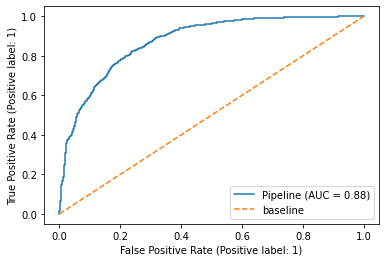

In [59]:
plot_roc_curve(best_nb, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--') # to simulate random guess 
plt.legend();

For a typical ROC curve, if AUC is **0.5**, the positive and negative populations overlap perfectly, and the model is as bad as can get, which is represented by the baseline. If the AUC is **1**, the positive and negative populations are perfectly separated, thus showing that the model is as good as it can get.

The ROC plot for the reccomended MNB model shows a fairly smooth curve with an AUC of **0.88** the model is a 88% chance that the model can distinguish between a post from TheOnion and nottheonion.

The optimal classification threshold is around 0.8, where we can maximise the true positives while keeping false positive rate at a manageable level. 

Lastly, this AUC of **0.88** which is relatively close to the maximum score of **1.0**. We can thus conclude that this model performs well!

An AUC between 0.8 - 0.9 is generally considered as 'excellent'<sup>2</sup> in the industry.

### True Positives vs False Positives & True Negatives vs False Negatives in recommended MNB model

In [60]:
pred_nb = best_nb.predict(X_test)
pred_nb_df = pd.DataFrame(pred_nb, columns=['preds']) # convert to dataframe for easy concatication
pred_nb_df.head()

,preds
0,1
1,1
2,0
3,1
4,1


True Negatives:954
False Positives:296
False Negatives:227
True Positives:1023


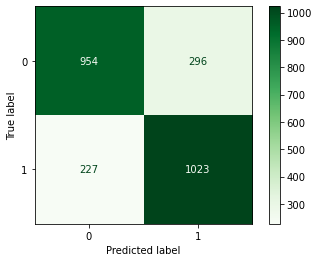

In [61]:
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, pred_nb).ravel()
print(f'True Negatives:{tn}\nFalse Positives:{fp}\nFalse Negatives:{fn}\nTrue Positives:{tp}')

# plot confusion matrix
plot_confusion_matrix(best_nb, X_test, y_test, cmap='Greens', values_format='d');

In [62]:
# concatinate the X_test and the predictions
pred_vs_actual_nb = pd.concat([pd.DataFrame(X_test).reset_index(drop=True), pd.DataFrame(y_test).reset_index(drop=True), pred_nb_df], axis=1)
print(pred_vs_actual_nb.shape)
pred_vs_actual_nb.head()

(2500, 3)


,new_text,onion,preds
0,why liberal white woman pay a lot of money to ...,0,1
1,goose thinking of migrating home a couple week...,1,1
2,hitman hire hitman who hire hitman who hire hi...,0,0
3,5 amber alert that were sent out that were cle...,1,1
4,sequel to original ghostbusters being made,1,1


In [63]:
# get the true positives
# true positives are 1 in both onion and preds column
true_positive_nb = pred_vs_actual_nb[(pred_vs_actual_nb.onion==1)&(pred_vs_actual_nb.preds==1)]
print(true_positive_nb.shape)
true_positive_nb.head()

(1023, 3)


,new_text,onion,preds
1,goose thinking of migrating home a couple week...,1,1
3,5 amber alert that were sent out that were cle...,1,1
4,sequel to original ghostbusters being made,1,1
10,dishwasher think he s mentoring younger dishwa...,1,1
13,new york time announces new columnist will con...,1,1


In [64]:
# get the true negatives
# true negatives are 0 in both onion and preds column
true_negative_nb = pred_vs_actual_nb[(pred_vs_actual_nb.onion==0)&(pred_vs_actual_nb.preds==0)]
print(true_negative_nb.shape)
true_negative_nb.head()

(954, 3)


,new_text,onion,preds
2,hitman hire hitman who hire hitman who hire hi...,0,0
5,the dea may have botched a cartel case over sl...,0,0
6,hangover cure the only way to avoid suffering ...,0,0
7,billionaire investor bill gross ordered to sto...,0,0
8,lady gaga offer 500 000 for return of dog afte...,0,0


In [65]:
# get the false positives
# false positives are 1 in onion and 0 in preds column
false_positive_nb = pred_vs_actual_nb[(pred_vs_actual_nb.onion==0)&(pred_vs_actual_nb.preds==1)]
print(false_positive_nb.shape)
false_positive_nb.head()

(296, 3)


,new_text,onion,preds
0,why liberal white woman pay a lot of money to ...,0,1
9,sadly marine are probably never going to space,0,1
15,amazon worker are listening to what you tell a...,0,1
23,column larry elder is the black face of white ...,0,1
33,senate peg tenure of igp to 4 year single term...,0,1


In [66]:
# get the false negatives
# false negatives are 0 in onion and 1 in preds column
false_negative_nb = pred_vs_actual_nb[(pred_vs_actual_nb.onion==1)&(pred_vs_actual_nb.preds==0)]
print(false_negative_nb.shape)
false_negative_nb.head()

(227, 3)


,new_text,onion,preds
12,death penalty for spitting on shopping trolley...,1,0
36,belarus s lukashenko meet opposition in kgb ja...,1,0
41,woman jealous of horse s eyelash,1,0
51,justin trudeau explains deep spiritual signifi...,1,0
56,delhi minister seek cancellation of singapore ...,1,0


To find out why false positives were classifed wrongly, we will look at their top 10 words by frequency and compare it with the top 10 words of the true positives.

Similarly, to find out why false negatives were classifed wrongly, we will look at their top 10 words by frequency and compare it with the top 10 words of the true negatives.

#### Comparison of Top 10 Words in True Positives and False Positives

In [68]:
# what are top words in true positive?
tp_words = [x for x in dict(pd.DataFrame(best_nb['cvec'].transform(true_positive_nb.new_text).toarray(),
             columns=best_nb['cvec'].get_feature_names()).sum().sort_values(ascending=False).head(10))]
print(tp_words)

['to', 'of', 'the', 'in', 'for', 'on', 'with', 'and', 'it', 'this']


In [70]:
# what are top words in false positive?
fp_words = [x for x in dict(pd.DataFrame(best_nb['cvec'].transform(false_positive_nb.new_text).toarray(),
             columns=best_nb['cvec'].get_feature_names()).sum().sort_values(ascending=False).head(10))]
print(fp_words)

['to', 'the', 'of', 'in', 'for', 'and', 'is', 'on', 'with', 'that']


In [71]:
# what are common top words in true positive and false positive?
positive_words = [x for x in fp_words if x in tp_words]
positive_words

['to', 'the', 'of', 'in', 'for', 'and', 'on', 'with']

Most of these words are stopwords like 'to', 'in', 'of' etc.

#### Comparison of True Negatives and False Negatives

In [72]:
# what are top words in true negative?
tn_words = [x for x in dict(pd.DataFrame(best_nb['cvec'].transform(true_negative_nb.new_text).toarray(),
             columns=best_nb['cvec'].get_feature_names()).sum().sort_values(ascending=False).head(10))]
print(tn_words)

['to', 'in', 'for', 'of', 'the', 'after', 'man', 'on', 'and', 'say']


In [73]:
# what are top words in false negative?
fn_words = [x for x in dict(pd.DataFrame(best_nb['cvec'].transform(false_negative_nb.new_text).toarray(),
             columns=best_nb['cvec'].get_feature_names()).sum().sort_values(ascending=False).head(10))]
print(fn_words)

['to', 'of', 'in', 'for', 'on', 'the', 'with', 'trump', 'from', 'after']


In [74]:
# what are common top words in true negative and false negative?
negative_words = [x for x in fn_words if x in tn_words]
negative_words

['to', 'of', 'in', 'for', 'on', 'the', 'after']

Similar to the true vs false positives above, most of these words are stop words.<br>
In conclusion, not much meaning can be derived from just looking at the common top words, as most, if not all, happen to be stopwords.

#### Coefficient Intepretation

In [90]:
nottheonion_importance = best_nb_model['mnb'].feature_log_prob_[0, :]
nottheonion_importance

array([-11.3058734 ,  -8.26656882, -10.98197007, ..., -11.3058734 ,
       -11.78797174, -11.78797174])

In [91]:
onion_importance = best_nb_model['mnb'].feature_log_prob_[1, :]
onion_importance

array([-11.81310773,  -8.42886747, -11.3310094 , ..., -11.81310773,
       -11.3310094 , -11.3310094 ])

In [93]:
df_features_nottheonion = pd.DataFrame(data=nottheonion_importance, columns=['coefficients'],
                                       index=best_nb_model['cvec'].get_feature_names())
print(df_features_nottheonion.shape)
df_features_nottheonion.head()

(77525, 1)


,coefficients
00,-11.305873
000,-8.266569
000 000,-10.981970
000 action,-11.305873
000 after,-10.737707


In [94]:
df_features_nottheonion.sort_values(by='coefficients', ascending=False).head(10)

,coefficients
to,-4.979568
in,-5.522082
of,-5.619676
the,-5.658035
for,-5.775209
on,-6.169657
and,-6.227528
after,-6.319837
with,-6.381832
man,-6.465912


Most of the words that predict nottheonion well are stop words, save for 'man'. Thus not much meaning can be derived from this.

In [95]:
df_features_theonion = pd.DataFrame(data=onion_importance, columns=['coefficients'],
                                       index=best_nb_model['cvec'].get_feature_names())
print(df_features_theonion.shape)
df_features_theonion.head()

(77525, 1)


,coefficients
00,-11.813108
000,-8.428867
000 000,-11.331009
000 action,-11.813108
000 after,-11.813108


In [96]:
df_features_theonion.sort_values(by='coefficients', ascending=False).head(10)

,coefficients
to,-4.863896
of,-5.267695
the,-5.644812
in,-5.723060
for,-5.954088
on,-6.309036
and,-6.485017
with,-6.500163
new,-6.669376
by,-6.672998


Similar to the coefficients above, most of the words that predict nottheonion well are stop words, save for 'new'. Thus not much meaning can be derived from this.

In conclusion, not much meaning can be derived from just looking at the common top words, as most, if not all, happen to be stopwords. This shows the extent of the 'blackboxness' of MNB, and why we still need to look at logistic regression for intepretability.

We can use the interpretability of the logistic regression model to study coefficients of the various features and see which words had the strongest impact on classification.

### Logistic Regression Coefficients

To study the coefficients, we will need to recreate the Logistic Regression model with the best parameters.

A quick recap on the best parameters.

In [97]:
gs_log.best_params_

{'cvec__max_df': 0.8,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None,
 'log__max_iter': 100,
 'log__penalty': 'l2',
 'log__random_state': 42}

In [98]:
# Instantiate the TfidfVectorizer with best parameters
cvec_log = CountVectorizer(max_df=0.8, max_features=None, min_df=1, ngram_range=(1,2), stop_words=None)

In [99]:
# fit_transform the training data and trainsform the test data
Z_train = cvec_log.fit_transform(X_train)
Z_test = cvec_log.transform(X_test)

In [100]:
# Instantiate the LogisticRegression with best parameters
log_best = LogisticRegression(max_iter=100, random_state=42, penalty='l2')

In [101]:
# fit the train data, and get the accuracy scores
log_best.fit(Z_train, y_train)
print(f'Train accuracy is {log_best.score(Z_train, y_train)}')
print(f'Test accuracy is {log_best.score(Z_test, y_test)}')

Train accuracy is 0.9997333333333334
Test accuracy is 0.7852


In [102]:
# get the other metrics
print(f'LogisticRegression test RECALL: {recall_score(y_test, log_best.predict(Z_test))}')
print(f'LogisticRegression test PRECISION: {precision_score(y_test, log_best.predict(Z_test))}')
print(f'LogisticRegression test f1 SCORE: {f1_score(y_test, log_best.predict(Z_test))}')

LogisticRegression test RECALL: 0.78
LogisticRegression test PRECISION: 0.788197251414713
LogisticRegression test f1 SCORE: 0.7840772014475271


The metrics for recreated Logistic Regression model match that of the hyperparamter tuned model. We can now start interpretating the coefficients.

The coefficents of the Logistic Regression are the Log(Odds Ratio)<sup>3</sup> of determining the positive class (TheOnion).

In [103]:
# creating index of feature names
index_log = cvec_log.get_feature_names()

In [104]:
# construct a dataframe of feature names and their respective coefficients
log_coef_df = pd.DataFrame(log_best.coef_[0],
                         columns=["coefficient"],
                         index=index_log)

In [105]:
# Top 5 words/ngrams

log_coef_df.sort_values(by='coefficient', ascending=False).head(10)

,coefficient
said what,1.566929
nation,1.549186
way,1.547807
announces,1.432677
shit,1.380316
all,1.370246
congress,1.303354
fucking,1.278267
self,1.227514
this,1.218810


In [106]:
# Bottom 5 words/ngrams
log_coef_df.sort_values(by='coefficient', ascending=False).tail(10)

,coefficient
say he,-1.240334
this is,-1.248961
accused,-1.261092
florida,-1.262506
snake,-1.284463
chicken,-1.286658
uk,-1.315480
are,-1.324158
toilet,-1.358766
police,-1.405872


In [107]:
top_coef_df = pd.concat([log_coef_df.sort_values(by='coefficient', ascending=False).head(10),
                           log_coef_df.sort_values(by='coefficient', ascending=False).tail(10)],
                       axis=0)
top_coef_df

,coefficient
said what,1.566929
nation,1.549186
way,1.547807
announces,1.432677
shit,1.380316
all,1.370246
congress,1.303354
fucking,1.278267
self,1.227514
this,1.218810


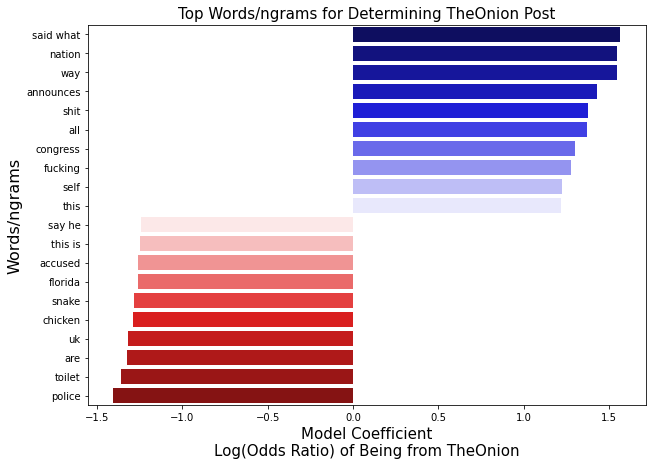

In [108]:
# plotting most significant coefs
plt.figure(figsize=(10, 7))
sns.barplot(data=top_coef_df,
            x="coefficient",
            y=top_coef_df.index,
            palette="seismic")
plt.title("Top Words/ngrams for Determining TheOnion Post", size=15)
plt.yticks(size=10)
plt.xticks(size=10)
plt.ylabel("Words/ngrams", size=16)
plt.xlabel("Model Coefficient\nLog(Odds Ratio) of Being from TheOnion", size=15);

#### Strong predictors of TheOnion (Fake News)
From the graph, we can see that key words like 'nation', 'announces', 'shit' , 'congress' and 'fucking' are strong indicators that a headline is from TheOnion, our fake news dataset.<br>
These words are not stopwords, and provide a clearer picture on the anatomy of TheOnion, ie fake news headline:
- Profanities such as 'shit' and 'fucking' are indicators that the news is fake, as creators of fake news have lesser restrictions on the language used in their headlines. To draw sentiment and capture the attention of the reader, such profanities may be used.
- The word 'announces' and 'congress' very likely go hand in hand in many fake news articles, as whenever 'congress or governments announces something', it will catch the attention of the reader. Fake news creators likely know this, and thus use it to their advantage.
- The word 'nation' also is a strong predictor. Anything that affects the 'nation' is bound to draw attention, and thus fake news creators may use this word often.
- An interesting one is the bigram 'said what'. These two words when used together with someone famous, conjures up feelings of controversy. For example 'Joe Biden Said What!' is a very eye catching headline that will garner more readership, and can be used by fake news creators. Such headlines are also a signature of tabloids, and thus will be rare in a real news headline.

#### Weak predictors of TheOnion (Fake News)
From the graph, we can see that key words like 'police', 'toilet', 'uk', 'chicken' , 'snake', 'florida' and 'accused' are weak indicators that a headline is from TheOnion, our fake news dataset.<br>
- The word 'Police' is a weak indicator, possibly because there are numerous real news articles invloving the police on a daily basis, on a variety of cases. Fake news creators may have a hard time keeping up in creating false scenarios invloving the police, who may be invloved in extreme and sometimes ridiculous cases quite frequently!
- The word 'uk' is a confusing one. It is likely to be the United Kingdom. Perhaps they are the most trustworthy country on earth? I am unable to draw any conclusions from this one.
- The words 'toilet and 'Florida' are noteworthy. There are many sensational incidents that happen in these 2 very different locations. Florida for example, has a whole fanbase based off the infamous 'Florida Man'<sup>4</sup> and his exploits. Fake news creators may not be able to create news as sensational as news involving toilets or Florida.
- The words 'snake' and 'chicken' are that of animals. If an animal ends up in the news, the scenario is probably sensational already, thus not as much value can be placed on a fake news article involving animals. Also, if the intention of fake news is to incite panic or cause harm, animals may not be the most efficient way to do so.
- The word 'accused' and the law have many things in common. In daily news, there are many articles of various individuals being 'accused' of 'multitude' of offenses. Similar to the 'police', fake news creators may have a hard time keeping up with new accusations happening on a frequent basis.

# Conclusions

We set out to create a model that was discerning enough to separate fake news from real news as well as being simple to use, and also minimize false positives and false negatives.

By choosing the Multinomial Naive Bayes(MNB) model as the recommended model, we are able to achieve good metrics, with a f1 score of **0.796419**, showing that this MNB model did in fact minimize the false positives and false negatives.<br>
This was further backed up by the ROC curve of the MNB model showing a an AUC of **0.88**, which is close to the maximum possible AUC of **1**. This model thus fulfils the 'minimize false positives and false negatives' criteria.<br>
Since the model is MNB, it is not very intepretableand thus is perfect for the general public, who just want to key in the news headline and get an answer whether it is likely to be fake news or not. It will also be easy to develop this model into an app, as the number of features required will be lesser.<br>
One good use case would be - a working class adult can easily caution to his/her elderly parents about a particular news being potentially fake, because "the government app said so".

However, should one require a model with greater intepretability, then Logistic Regression should be chosen. This model also performed well on our dataset, with metrics close to that of the MNB model.<br>
Government bodies such as the police can use the intepretability of the model to educate members of the public on how to spot potential fake news.<br>
For example, the public can be warned that news that sounds very tabliod-ish, or uses profanities have a higher chance of being fake. Another example would be that if a news source seemingly 'quotes' governments or people of influence such a CEO, memebers of the public can be advised to substantiate this information with news from reputable, official sources, such as The Straits Times.

# Recommendations for Improvement

Despite the chosen Multinomial Naive Bayes(MNB) performing well, it was still overfit nonetheless. The limitation here is that the models used were considered relatively more simple. More advanced techniques, such as using TENSORFLOW and BERT, could be used in the future to generate models with strong metrics, as well as reduced overfitting.

BERT (Bidirectional Encoder Representations from Transformers) is a state of the art model developed by Google. As opposed to directional models, which read the text input sequentially (left-to-right or right-to-left), the Transformer encoder reads the entire sequence of words at once. Therefore it is considered bidirectional, though it would be more accurate to say that it’s non-directional. This characteristic allows the model to learn the context of a word based on all of its surroundings (left and right of the word).<sup>5</sup>

Another limitation of the chosen MNB model is that it can only predict English headlines. In a multi-racial society such as Singapore, fake news can come in many languages. This can be especially dangerous to elderly folk, who mostly converse in their mother tongue. Further study and development of the model to accept other languages can be explored.

Lastly, the datasets were pulled from sometime between end 2018 to end 2021, a 3 year time span. The hot topics may change over the course of 2022 and beyond, so this model needs to be constantly re-trained on the most updated news topics for it to stay relevant.

# References
1. https://www.analyticsvidhya.com/blog/2020/11/a-tour-of-evaluation-metrics-for-machine-learning/
2. https://www.statology.org/what-is-a-good-auc-score/
3. https://quantifyinghealth.com/interpret-logistic-regression-coefficients/
4. https://www.reddit.com/r/FloridaMan/
5. https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270